In [1]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
SEED = 428
SIZE = 100

SMC_STEPS = 10000
MET_STEPS = 10000

# Data Generation

In [3]:
def gaussian_mixture(mu1=0, sigma1=1,
                     mu2=5, sigma2=2,
                     rho=0.5,
                     size=100, random_state=None):
    rnd = np.random.RandomState(random_state)
    x = []
    for _ in range(size):
        if rnd.rand() < rho:
            x.append(rnd.normal(loc=mu1, scale=sigma1))
        else:
            x.append(rnd.normal(loc=mu2, scale=sigma2))
    return np.array(x)

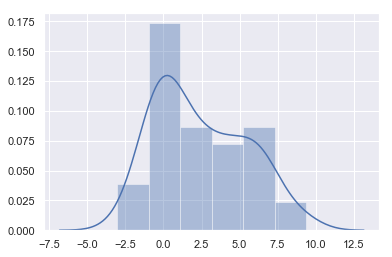

In [5]:
x = gaussian_mixture(rho=0.5, size=SIZE, random_state=SEED)
sns.distplot(x)

# Models

## Model 1
Use separate `mu` but common `sigma` for both Gaussians. Fix `rho` at 0.5.

In [6]:
with pm.Model() as model_1:
    w = pm.floatX([.5, .5])
    mu1 = pm.Uniform("mu1", lower=-10, upper=10)
    mu2 = pm.Uniform("mu2", lower=-10, upper=10)
    sigma = pm.Uniform("sigma", lower=0, upper=5)
    
    means = tt.zeros([2])
    means = tt.set_subtensor(means[0], mu1)
    means = tt.set_subtensor(means[1], mu2)
    
    sigmas = tt.zeros([2])
    sigmas = tt.set_subtensor(sigmas[0], sigma)
    sigmas = tt.set_subtensor(sigmas[1], sigma)
    
    obs = pm.NormalMixture("obs", w=w, 
                           mu=means, 
                           sigma=sigmas, 
                           observed=x)

In [7]:
model_1.basic_RVs

[mu1_interval__, mu2_interval__, sigma_interval__, obs]

## Model 2
Use separate `mu` and `sigma` for both Gaussians. Fix rho at 0.5.

In [8]:
with pm.Model() as model_2:
    w = pm.floatX([.5, .5])
    mu1 = pm.Uniform("mu1", lower=-10, upper=10)
    mu2 = pm.Uniform("mu2", lower=-10, upper=10)
    sigma1 = pm.Uniform("sigma1", lower=0, upper=5)
    sigma2 = pm.Uniform("sigma2", lower=0, upper=5)
    
    means = tt.zeros([2])
    means = tt.set_subtensor(means[0], mu1)
    means = tt.set_subtensor(means[1], mu2)
    
    sigmas = tt.zeros([2])
    sigmas = tt.set_subtensor(sigmas[0], sigma1)
    sigmas = tt.set_subtensor(sigmas[1], sigma2)
    
    obs = pm.NormalMixture("obs", w=w, 
                           mu=means, 
                           sigma=sigmas, 
                           observed=x)

In [9]:
model_2.basic_RVs

[mu1_interval__, mu2_interval__, sigma1_interval__, sigma2_interval__, obs]

## Model 3
Use separate `mu` and `sigma` for both Gaussians. rho uniformly distributed [0, 1].

In [10]:
with pm.Model() as model_3:
    rho = pm.Uniform("rho", lower=0, upper=1)
    
    mu1 = pm.Uniform("mu1", lower=-10, upper=10)
    mu2 = pm.Uniform("mu2", lower=-10, upper=10)
    
    sigma1 = pm.Uniform("sigma1", lower=0, upper=5)
    sigma2 = pm.Uniform("sigma2", lower=0, upper=5)
    
    w = tt.zeros([2])
    w = tt.set_subtensor(w[0], rho)
    w = tt.set_subtensor(w[1], 1 - rho)
    
    means = tt.zeros([2])
    means = tt.set_subtensor(means[0], mu1)
    means = tt.set_subtensor(means[1], mu2)
    
    sigmas = tt.zeros([2])
    sigmas = tt.set_subtensor(sigmas[0], sigma1)
    sigmas = tt.set_subtensor(sigmas[1], sigma2)
    
    obs = pm.NormalMixture("obs", w=w, 
                           mu=means, 
                           sigma=sigmas, 
                           observed=x)

In [11]:
model_3.basic_RVs

[rho_interval__,
 mu1_interval__,
 mu2_interval__,
 sigma1_interval__,
 sigma2_interval__,
 obs]

# Calculation of Bayes factors using sequential MC

## Model 2 vs model 1 for data set `x1`

In [12]:
with model_1:
    tr_smc_m1 = pm.sample(SMC_STEPS, step=pm.SMC(), random_seed=SEED)
    
marg_llh_m1 = model_1.marginal_likelihood
print("Log10 Marginal likelihood of model_1: %0.5f" % np.log10(marg_llh_m1))

Sample initial stage: ...
Stage: 0 Beta: 0.012 Steps: 25
Stage: 1 Beta: 0.051 Steps: 11
Stage: 2 Beta: 0.134 Steps: 3
Stage: 3 Beta: 0.289 Steps: 9
Stage: 4 Beta: 0.564 Steps: 5
Stage: 5 Beta: 1.000 Steps: 17


Log10 Marginal likelihood of model_1: -109.09833


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c212fe940>,
      dtype=object)

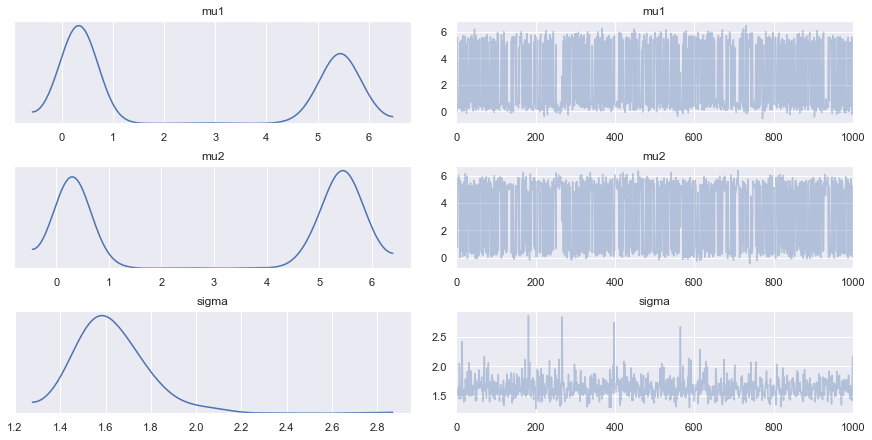

In [14]:
pm.traceplot(tr_smc_m1[::10])

In [ ]:
with model_x1_m2:
    tr_smc_x1_m2 = pm.sample(SMC_STEPS, step=pm.SMC(), random_seed=SEED)
    
marg_llh_x1_m2 = model_x1_m2.marginal_likelihood
print("Log10 Marginal likelihood of model_x1_m2: %0.5f" % np.log10(marg_llh_x1_m2))

In [ ]:
pm.traceplot(tr_smc_x1_m2[::10])

In [ ]:
print("Log10 Bayes factor of model_x1_m2 over model_x1_m1: %0.5f" %(np.log10(marg_llh_x1_m2) 
                                                                    - np.log10(marg_llh_x1_m1)) )

So the Bayes factor refers the simpler model `marg_llh_x1_m1`.

## Model 2 vs model 1 for data set `x2`

In [ ]:
with model_x2_m1:
    tr_smc_x2_m1 = pm.sample(SMC_STEPS, step=pm.SMC(), random_seed=SEED)
    
marg_llh_x2_m1 = model_x2_m1.marginal_likelihood
print("Log10 Marginal likelihood of model_x2_m1: %0.5f" % np.log10(marg_llh_x2_m1))

In [ ]:
pm.traceplot(tr_smc_x2_m1[::10])

In [ ]:
with model_x2_m2:
    tr_smc_x2_m2 = pm.sample(SMC_STEPS, step=pm.SMC(), random_seed=SEED)
    
marg_llh_x2_m2 = model_x2_m2.marginal_likelihood
print("Log10 Marginal likelihood of model_x2_m2: %0.5f" % np.log10(marg_llh_x2_m2))

In [ ]:
pm.traceplot(tr_smc_x2_m2[::10])

In [ ]:
print("Log10 Bayes factor of model_x2_m2 over model_x2_m1: %0.5f" %(np.log10(marg_llh_x2_m2) 
                                                                    - np.log10(marg_llh_x2_m1)) )